In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import io as io
import math, copy

rcdef = plt.rcParams.copy()
newparams_for_screen = {'axes.labelsize': 14, 'axes.linewidth': 0.75, 'savefig.dpi': 100,
             'lines.linewidth': 0.6, 'figure.figsize': (8, 6),
             'ytick.labelsize': 12, 'xtick.labelsize': 12, 'axes.titlesize': 14,
             'legend.fontsize': 10, 'legend.frameon': True,
             'legend.handlelength': 1.5}
plt.rcParams.update(newparams_for_screen)

### Exercise 1.1
To see roundoff error in action, write a program to find the value of e for which $1+\epsilon=1$. Start with $\epsilon=1$ and iterate, halving $\epsilon$ each iteration unit $1+\epsilon=1$. This last value of $\epsilon$ for which this was not true is the machine epsilon. You will get a different value for single- vs. double-precision floating point arithmetic.

In [9]:
def CHT_E1_1():
    one = 1.0; epsilon = 1e0
    while (one+epsilon != 1.0):
        epsilon /= 2 # use half because machine is computing using binary system
    print("The machine epsilon (double) is", epsilon)

# run it
CHT_E1_1()

The machine epsilon (double) is 1.1102230246251565e-16


### Exercise 1.2

>We will be concerned with the order-of-accuracy of our methods, and a good way to test whether our method is behaving properly is to perform a convergence test. Consider our 5th-order accurate approximation to sin(x) above. Pick a range of $x$’s ($<1$), and compute the error in our approximation as $\epsilon = \sin(x) - [x - x^3/6]$, and show that as you cut $x$ in half, $\epsilon$ reduces by $2^5$—demonstrating 5th-order accuracy.
>This can be proved by substraction: $\epsilon(x) \propto x^5$ and $\epsilon(x/2) \propto (x/2)^5$ $\Rightarrow$ $\epsilon(x)/\epsilon(x/2) \approx 32$

In [9]:
def CHT_E1_2():
    def err_sin_trucation(x):
        return math.sin(x) - (x - x**3/6)
    print(u"epsilon reduces by", err_sin_trucation(0.5)/err_sin_trucation(0.25))

# run it
CHT_E1_2()

epsilon reduces by 31.85754962376605


### Exercise 1.3
>Show that a centered difference, $\partial{a}/\partial{x}|_i = (a_{i+1} - a_{i-1})/(2\Delta x)$, is second order accurate, i.e. its truncation error is $O(\Delta x^2)$.

Here we have
$$a_{i+1} = a_i + \Delta x \frac{\partial{a}}{\partial{x}}|_i + \beta_2\Delta x^2 + \beta_3\Delta x^3 + \cdots ~~~~~
a_{i-1} = a_i - \Delta x \frac{\partial{a}}{\partial{x}}|_i + \beta_2\Delta x^2 - \beta_3\Delta x^3 + \cdots$$

$$\Rightarrow \frac{\partial{a}}{\partial{x}}|_i = \frac{a_{i+1} - a_i + a_i - a_{i-1}}{2\Delta x} +  - \frac{2\beta_3\Delta x^3}{2\Delta x} + \cdots = \frac{a_{i+1} - a_{i-1}}{2\Delta x} + O(\Delta x^2) $$

Justified.

### Exercise 1.4
Consider a function, $f(x)$, sampled at three equally-spaced points, $a, b, c$, with corresponding function values $f_a, f_b, f_c$. Derive the expression for Simpson’s rule by fitting a quadratic $\hat{f}(x) = A(x-a)^2+B(x-a)+C$ to the three points, and then analytically integrating $\hat{f}(x)$ in the interval $[a, c]$. You should find
$$I = \frac{c-a}{6}(f_a + 4f_b + f_c)$$
Note that $(c-a)/6 = \Delta x/3$

So
$$\hat{f}(a) = C ~~~~~ \hat{f}(b) = A\Delta x^2 + B\Delta x + C ~~~~~ \hat{f}(c) = 4A\Delta x^2 + 2B\Delta x + C$$
$$\therefore C = f_a ~~~~~ B = (4f_b - f_c - 3f_a)/(2\Delta x) ~~~~~ A = (f_c - 2f_b + f_a)/(2\Delta x^2)$$
Then
$$\int_{a}^{c} \hat{f}(x) = \left(\frac{A}{3}(x-a)^3 + \frac{B}{2}(x-a)^2 + Cx\right)|_{a}^{c} = \frac{8A}{3} \Delta x^3 + 2B \Delta x^2 + C(c-a) $$
$$ = \frac{4}{3}(f_c-2f_b+f_a) \Delta x + (4f_b-f_c-3f_a) \Delta x + 2f_a \Delta x $$
$$ = \left(\frac{1}{3}f_a + \frac{4}{3}f_b + \frac{1}{3}f_c \right) \Delta x = \frac{c-a}{6}(f_a + 4f_b + f_c) $$

### Exercise 1.5
Consider the orbit of Earth around the Sun. If we work in the units of astronomical units, years, and solar masses, then Newton’s gravitational constant and the solar mass together are simply $GM = 4π^2$ (this should look famaliar as Kepler’s third law). We can write the ODE system describing the motion of Earth as:
$$\dot{\mathbf{x}} = \mathbf{v}$$
$$\dot{\mathbf{v}} = -\frac{GM\mathbf{r}}{r^3}$$
If we take the coordinate system such that the Sun is at the origin, then,
$$\mathbf{x} = (x, y)^T$$
is the position of the Earth and $\mathbf{\hat{r}} = x\mathbf{\hat{x}} + y\mathbf{\hat{y}}$ is the radius vector pointing from the Sun to the Earth.
Integrate this system for a single orbital period with the first-order Euler and the RK4 method and measure the convergence by integrating at a number of different $\Delta t$’s. *Note: you’ll need to define some measure of error, you can consider a number of different metrics, e.g., the change in radius after a single orbit.*

In [4]:
def CHT_E1_5():
    class vector_2D: # define a 2D vector class for vector calculation
        def comp_r_angle(self): # compute |r| and angle once (x,y) has changed
            self.r = np.sqrt(self.x1**2+self.x2**2)
            self.angle = math.atan2(self.x2, self.x1) # between (-pi, pi] in radians
        def __init__(self, x1, x2): # constructor function
            self.x1 = x1
            self.x2 = x2
            self.comp_r_angle()
        def __add__(self, other_value): # overload the return value of self + other_value
            temp = copy.deepcopy(self)
            if isinstance(other_value, vector_2D):
                temp.x1 += other_value.x1
                temp.x2 += other_value.x2
            else:
                print("Warning: only vectors can be added onto vectors.")
                print("Now treating", other_value, "as ("+str(other_value)+", "+str(other_value)+").")
                temp.x1 += other_value
                temp.x2 += other_value
            temp.comp_r_angle()
            return temp
        def __radd__(self, other_value): # overload the return value of other_value + self
            return self.__add__(other_value)
        def __iadd__(self, other_value): # overload self += other_value
            return self.__add__(other_value)
        def __mul__(self, other_value): # overload the return value of dot product: self * other_value
            if isinstance(other_value, vector_2D):
                return self.x1*other_value.x1 + self.x2*other_value.x2
            else:
                temp = copy.deepcopy(self)
                temp.x1 *= other_value
                temp.x2 *= other_value
                temp.comp_r_angle()
                return temp
        def __rmul__(self, other_value): # overload the return value of dot product: other_value * self
            return self.__mul__(other_value)
        def __imul__(self, other_value): # overload self *= other_value
            return self.__mul__(other_value)
        def __sub__(self, other_value): # overload the return value of self - other_value
            return self.__add__(other_value*(-1))
        def __rsub__(self, other_value): # overload the return value of other_value - self
            temp = copy.deepcopy(self)
            temp *= (-1)
            return self.__add__(other_value)
        def __isub__(self, other_value): # overload self -= other_value
            return self.__sub__(other_value)
        def __truediv__(self, other_value): # overload division: self / other_value
            if isinstance(other_value, vector_2D):
                if other_value.angle != self.angle:
                    raise TypeError("A vector cannot be divided by another vector with a different orientation.")
                else:
                    return self.x1/other_value.x1
            else:
                return self.__mul__(1/other_value)
        def __rtruediv__(self, other_value): # overload division: other_value / self
            if isinstance(other_value, vector_2D):
                if other_value.angle != self.angle:
                    raise TypeError("A vector cannot be divided by another vector with a different orientation.")
                else:
                    return other_value.x1/self.x1
            else:
                raise SyntaxError("A vector cannot be a divisor of a scalar.")
        def __itruediv__(self, other_value): # overload self /= other_value
            return self.__div__(other_value)
        def showme(self): # print vector info
            print("(x,y)=("+str(self.x1)+", "+str(self.x2)+"), |r|="+str(self.r)+", angle="+str(self.angle)+"[rad].")
            
    class Earth_motion: # define a class to compute the Earth motion          
        def __reset__(self):
            self.r = vector_2D(1.0, 0.0)
            self.v = vector_2D(0.0, 2*np.pi)
            self.dt = 0.0
            self.t = 0.0
            self.t_end = 1.0
            self.step = 0
            self.path = np.zeros([1,2])
        def __init__(self):
            self.__reset__()
        def __setattr__(self, name, value): # make sure r, v both are vector
            if (name == "r" or name == "v") and (not isinstance(value, vector_2D)):
                raise AttributeError("Only vector_2D is allowed to assign to this member.")
            self.__dict__[name] = value    
        def __dot_v__(self, usr_r): # to simplify the code
            return (-4*np.pi**2/(usr_r.r**3)) * usr_r
        def onestep_1st_Euler(self): # one step forward for 1st-order Euler method
            original_r = self.r
            self.r += (self.v * self.dt)
            self.v += self.__dot_v__(original_r) * self.dt
        def onestep_semi_implicit_Euler(self): # one step forward for backward Euler method
            self.v += self.__dot_v__(self.r) * self.dt
            self.r += self.v * self.dt
        def onestep_RK4(self): # one step forward for RK4 method
            v_1 = self.v; a_1 = self.__dot_v__(self.r)
            v_2 = self.v+a_1*self.dt/2; a_2 = self.__dot_v__(self.r+v_1*self.dt/2)
            v_3 = self.v+a_2*self.dt/2; a_3 = self.__dot_v__(self.r+v_2*self.dt/2)
            v_4 = self.v+a_3*self.dt; a_4 = self.__dot_v__(self.r+v_3*self.dt)
            self.r += (v_1+2*v_2+2*v_3+v_4) * self.dt/6
            self.v += (a_1+2*a_2+2*a_3+a_4) * self.dt/6
        def record_path(self): # prepare for ploting trajectory
            self.path[self.step, 0] = self.r.x1
            self.path[self.step, 1] = self.r.x2
            self.step += 1
        def draw_path(self): # draw the trajectory
            fig = plt.figure(1)
            ax = fig.add_subplot(1,1,1)
            ax.plot(self.path[:self.step, 0], self.path[:self.step, 1])
            ax.set_xlim([-1.6, 1.6])
            ax.set_ylim([-1.2, 1.2])
            plt.show()
            plt.close('all')
        def convergence_test(self, method):
            all_dt = np.array([1e-3, 5e-4, 2.5e-4])
            for temp_dt in all_dt:
                self.__reset__()
                self.dt = temp_dt
                self.path = np.zeros([self.t_end/self.dt+2, 2])
                self.record_path()
                while (self.t <= self.t_end and np.abs(self.t+self.dt-self.t_end)<np.abs(self.t-self.t_end)):
                    method()
                    self.record_path()
                    self.t += self.dt
                #self.r.showme()
                error_vector = self.r - vector_2D(1.0, 0.0)
                print("dt = ", self.dt, ", T_end =", self.t, ";  Error Vector [final_point - (1,0)] info:");
                error_vector.showme()
                #self.draw_path() # uncomment this line to draw the trajectory
    # After defining two class, now test convergence        
    Em_Euler = Earth_motion()
    Em_Euler_Cromer = Earth_motion()
    Em_RK4 = Earth_motion()
    print("Euler method:")
    Em_Euler.convergence_test(Em_Euler.onestep_1st_Euler)
    print("Euler-Cromer method:")
    Em_Euler_Cromer.convergence_test(Em_Euler_Cromer.onestep_semi_implicit_Euler)
    print("RK4 method:")
    Em_RK4.convergence_test(Em_RK4.onestep_RK4)
        
# run it
CHT_E1_5()

Euler method:
dt =  0.001 , T_end = 1.0 ;  Error Vector [final_point - (1,0)] info:
(x,y)=(0.0155719248047, -0.358194089079), |r|=0.358532411775, angle=-1.5273502555368315[rad].
dt =  0.0005 , T_end = 1.0 ;  Error Vector [final_point - (1,0)] info:
(x,y)=(0.0225932993787, -0.183277059939), |r|=0.184664392552, angle=-1.4481411212396147[rad].
dt =  0.00025 , T_end = 1.0 ;  Error Vector [final_point - (1,0)] info:
(x,y)=(0.0153820684357, -0.0924344967012), |r|=0.0937056252835, angle=-1.4058969280008522[rad].
Euler-Cromer method:
dt =  0.001 , T_end = 1.0 ;  Error Vector [final_point - (1,0)] info:
(x,y)=(3.41732198095e-07, -0.000175702464974), |r|=0.000175702797299, angle=-1.5688513810182816[rad].
dt =  0.0005 , T_end = 1.0 ;  Error Vector [final_point - (1,0)] info:
(x,y)=(4.36811351534e-08, -4.39255723671e-05), |r|=4.39255940861e-05, angle=-1.5698018919269894[rad].
dt =  0.00025 , T_end = 1.0 ;  Error Vector [final_point - (1,0)] info:
(x,y)=(5.5204378846e-09, -1.09813904777e-05), |r|=1

### Exercise 2.1
Show that
$$\langle f\rangle_i = \frac{1}{\Delta x} \int^{x_i-1/2}_{x_i+1/2} f(x)dx \sim f(x_i)$$
is true to $O(\Delta x^2)$ by expanding $f(x)$ as a Taylor series in the integral.


$$\langle f\rangle_i = \frac{1}{\Delta x} \int^{x_i-1/2}_{x_i+1/2} \left[ f(x_i)+f'(x_i)(x-x_i)+\frac{1}{2}f''(x_i)(x-x_i)^2 + \cdots \right]dx \sim f(x_i)$$
Because $(x-x_i)$ is an even function, so the definite integral of itself, which is $O(\Delta x)$ leads to 0. Therefore
$$\langle f\rangle_i = f(x_i) + O(\Delta x^2)$$


### Exercise 2.2
A conservative interpolant is used to reconstruct a continuous functional form, f(x), from a collection of cell-averages. A key requirement is that when f(x) is averaged over a cell, it returns the cell-average.

The following code are from hydro_examples: conservative-interpolation.ipynb 

In [1]:
from sympy import init_session
init_session()

IPython console for SymPy 0.7.6 (Python 3.4.3-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://www.sympy.org


#### Quadratic
We want to construct a quadratic polynomal through that points $x_{i-1}$, $x_i$, $x_{i+1}$ that gives the correct averages,
$f_{i-1}$, $f_i$, and $f_{i-1}$ when integrated over the volume, e.g.

$$\frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} f(x) dx = f_i$$

There are 3 unknowns in the quadratic and three constraints, so this is a linear system we can solve.

Define the quadratic polynomial

In [2]:
a, b, c = symbols("a b c")
x0 = symbols("x0")
f = a*(x-x0)**2 + b*(x-x0) + c
f

In [3]:
dx = symbols("\Delta")

#### constraints
Define the 3 constraint equations---here we set them up construct $A$, $B$, and $C$ as the integrals over the 3 control volumes

In [4]:
fm, f0, fp = symbols("f_{i-1} f_i f_{i+1}")
#xm32, xm12, xp12, xp32 = symbols("x_{i-3/2} x_{i-1/2} x_{i+1/2} x_{i+3/2}")
xm32 = x0 - Rational(3,2)*dx
xm12 = x0 - Rational(1,2)*dx
xp12 = x0 + Rational(1,2)*dx
xp32 = x0 + Rational(3,2)*dx

interfaces

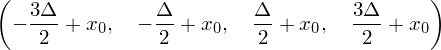

In [5]:
xm32, xm12, xp12, xp32

In [6]:
A = simplify(integrate(f/dx, (x, xm32, xm12)))
B = simplify(integrate(f/dx, (x, xm12, xp12)))
C = simplify(integrate(f/dx, (x, xp12, xp32)))

The analytic forms of the integrals

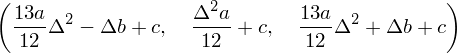

In [7]:
A, B, C

Our linear system is now:

$$A = f_{i-1}$$
$$B = f_i$$
$$C = f_{i+1}$$

Now find the coefficients of the polynomial

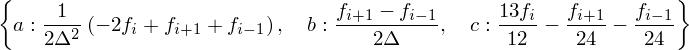

In [8]:
coeffs = solve([A-fm, B-f0, C-fp], [a,b,c])
coeffs

And in pretty form, here's the polynomial

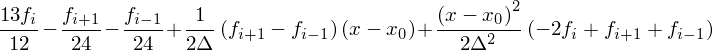

In [9]:
f.subs(a,coeffs[a]).subs(b,coeffs[b]).subs(c,coeffs[c])

### Exercise 3.1
$$a_t + ua_x = 0$$
Show that $a(x − ut)$ is a solution to this equation for any choice of a. This means that the solution is constant along the lines $x = ut$ (the curves along which the solution is constant are called the characteristics).

Since a is any differentiable function, it is easy to obtain
$$a_t+ua_x = a'(x-ut)\frac{\partial(x-ut)}{\partial t} + u a'(x-ut)\frac{\partial(x-ut)}{\partial x}$$
$$\Rightarrow ~ a_t+ua_x = -u a'(x-ut) + u a'(x-ut) = 0$$
So $a(x-ut)$ is a solution. Once we know the initial condition $a(x,0)$, we also know the solution $a(x-ut)$ at any $t$.

### Exercise 3.2
Show analytically that when you use $C = 1$ in the first-order differenced advection equation (below) that you advect the profile exactly, without any numerical error.
$$\frac{a_i^{n+1}-a_i^{n}}{\Delta t} = -u\frac{a_i^{n}-a_{i-1}^n}{\Delta x}$$
where $a_i^n = a(x_i, t^n)$, and $\Delta t = C\frac{\Delta x}{u}$.

Substitue $C=1$, and then $\Delta t = \Delta x/u$, it is easy to show
$$ a_i^{n+1} - a_i^{n} = -(a_i^n - a_{i-1}^n)$$
$$\Rightarrow a_i^{n+1} = a_{i-1}^n$$
which means the profile is exactly advected without any numerical error.

### Exercise 3.3
Write a code to solve the 1-d linear advection equation using the discretization of (1st Eq of E3.2) on the domain $[0, 1]$ with $u = 1$ and periodic boundary conditions. For initial conditions, try both a Gaussian profile and a top-hat:
$$a = \left\{
\begin{array}{ccccc}      
    0 & if &       &x& < 1/3 \\
    1 & if & 1/3 < &x& < 2/3 \\
    0 & if & 2/3 < &x&       
\end{array}\right.$$
Note: For a general treatment of boundary conditions, you would initialize the ghost points to their corresponding periodic data and apply the difference equations to zones $0, \dots , N − 1$. However, for periodic BCs on this grid, points $0$ and $N − 1$ are identical, so you could do the update in this special case on points $1, \dots, N − 1$ without the need for ghost points and then set $a_0 = a_{N−1}$ after the update.

Run you program for one or more periods (one period is $T = 1/u$) with several different CFL numbers and notice that there is substantial numerical dissipation.

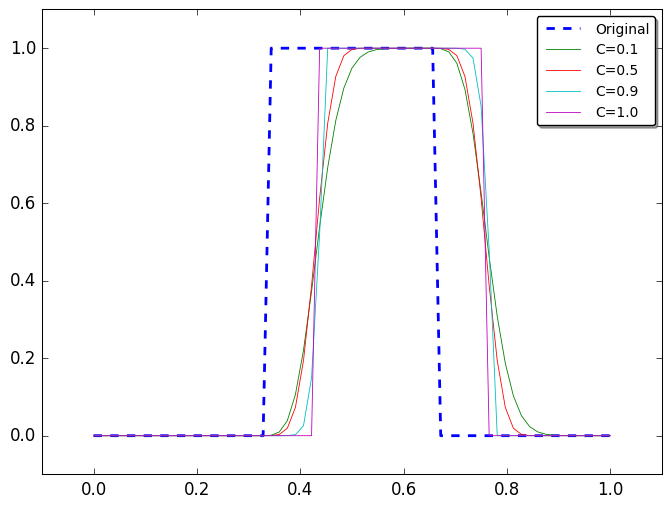

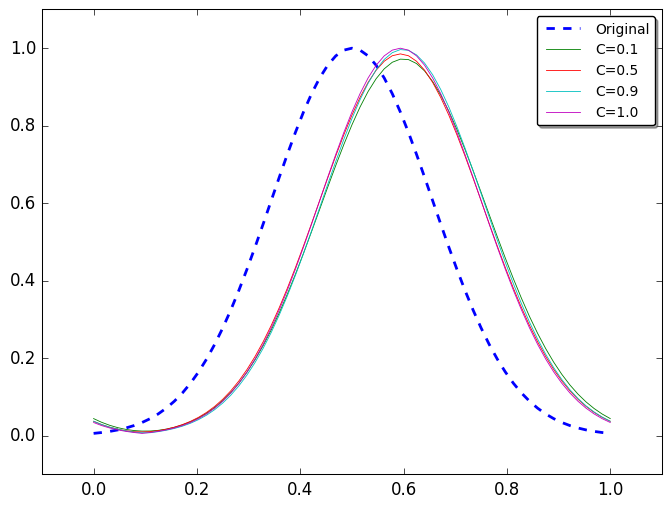

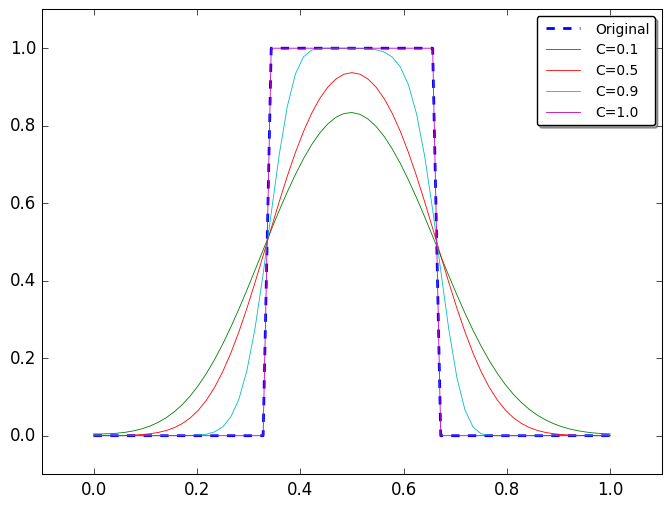

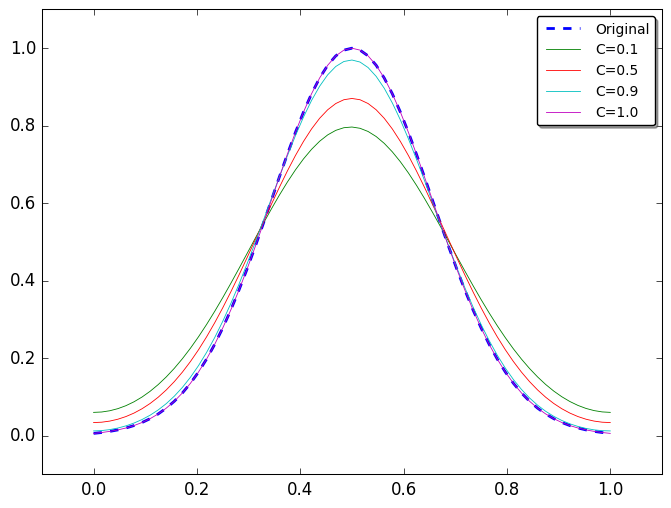

In [14]:
def CHT_E3_3():
    import scipy.signal as signal
    class Profile:
        def __init__(self, N, shape): # N = number of finite-difference points - 1
            self.x, self.dx, self.u = np.arange(N)/(N-1), 1./(N-1), 1.0
            self.T = 1.0/self.u
            self.a = np.zeros(N)
            if shape == "Gaussian":
                self.a = signal.gaussian(N, std=int(N/6))
            elif shape == "top-hat":
                self.a[np.logical_and(self.x >= 1./3., self.x <= 2./3.)] = 1.0
            else:
                print("Unrecognized shape.")
                return
        def update(self, nT, C): # nT = number of periods to run, C = CFL number
            self.dt = C * self.dx / self.u
            for i in range(int(nT/self.dt)):
                temp_a = np.roll(self.a, 1)
                self.a = self.a - C * (self.a - temp_a)
                self.a[0] = self.a[-1]
    
    def compareC(N, shape, nT):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        Cs = [0.1, 0.5, 0.9, 1.0]
        pf = Profile(N, shape)
        ax.plot(pf.x, pf.a, "--", lw=2, label="Original")
        ax.set_ylim([-0.1, 1.1])
        ax.set_xlim([-0.1, 1.1])
        for item in Cs:
            pf = Profile(N, shape)
            pf.update(nT, item)
            ax.plot(pf.x, pf.a, label=r"C="+str(item))
        leg = ax.legend(loc="best", handlelength=3, fancybox=True, shadow=True)
        leg.get_frame().set_alpha(1.0)
        plt.show()    
        plt.close("all")
    
    compareC(65, "top-hat", 0.1)
    compareC(65, "Gaussian", 0.1)
    compareC(65, "top-hat", 1)
    compareC(65, "Gaussian", 1)
CHT_E3_3()

### Exercise 3.4
You may think that using a centered-difference for the spatial derivative, $u_x ∼ (u_{i+1} − u_{i−1})/(2\Delta x)$ would be more accurate. This method is called FTCS (forward-time, centered-space). Try this. You will find that the solution is unconditionally unstable.

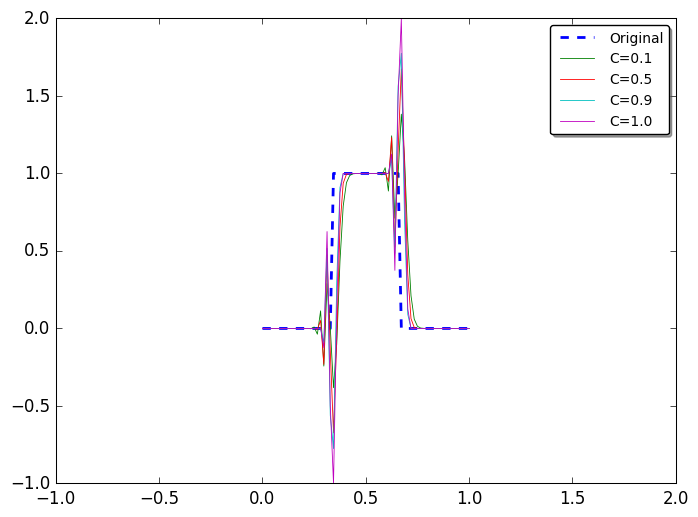

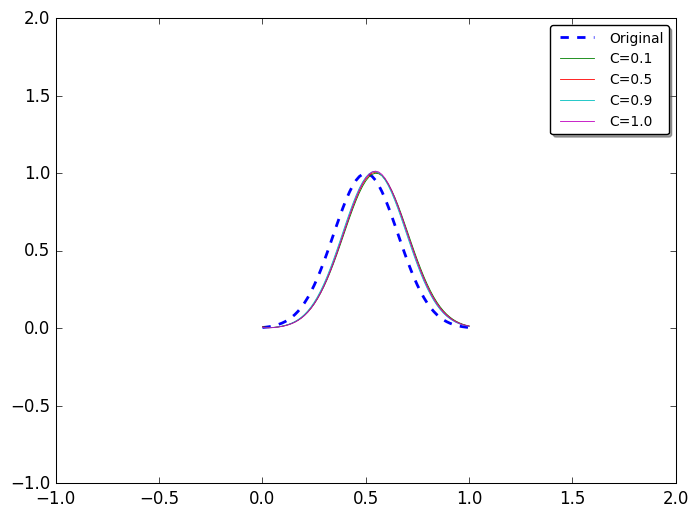

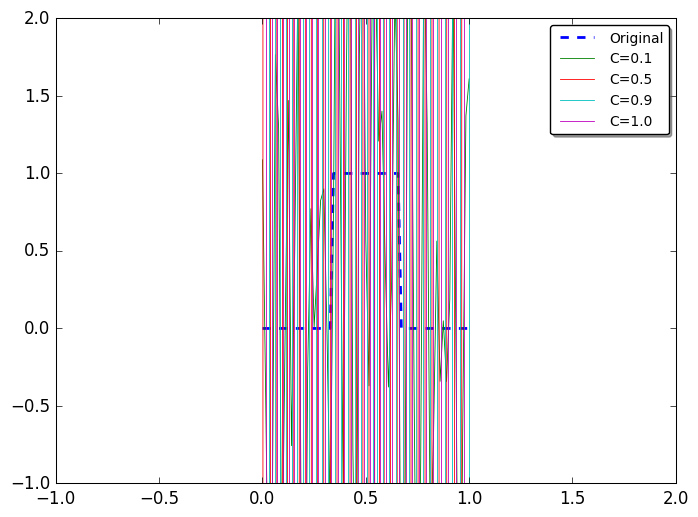

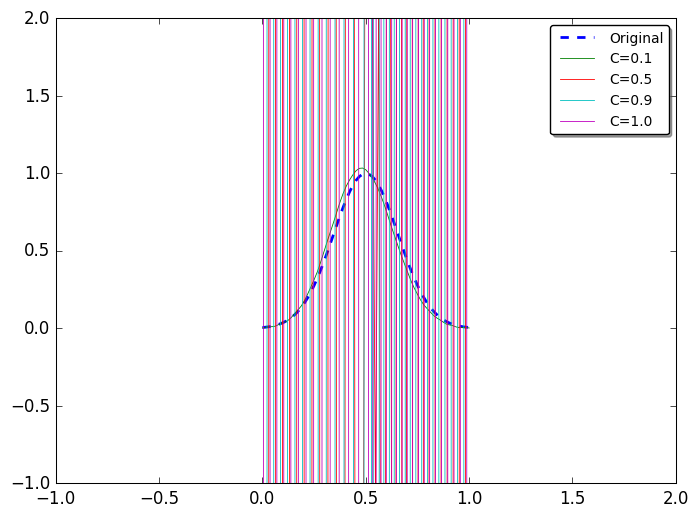

In [15]:
def CHT_E3_4():
    import scipy.signal as signal
    class Profile:
        def __init__(self, N, shape): # N = number of finite-difference points - 1
            self.x, self.dx, self.u = np.arange(N)/(N-1), 1./(N-1), 1.0
            self.T = 1.0/self.u
            self.a = np.zeros(N)
            if shape == "Gaussian":
                self.a = signal.gaussian(N, std=int(N/6))
            elif shape == "top-hat":
                self.a[np.logical_and(self.x >= 1./3., self.x <= 2./3.)] = 1.0
            else:
                print("Unrecognized shape.")
                return
        def update(self, nT, C): # nT = number of periods to run, C = CFL number
            self.dt = C * self.dx / self.u
            for i in range(int(nT/self.dt)):
                a_left_value = np.roll(self.a, 1)
                a_right_value = np.roll(self.a, -1)
                self.a = self.a - C/2 * (a_right_value - a_left_value)
    
    def compareC(N, shape, nT):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        Cs = [0.1, 0.5, 0.9, 1.0]
        pf = Profile(N, shape)
        ax.plot(pf.x, pf.a, "--", lw=2, label="Original")
        ax.set_ylim([-1, 2])
        ax.set_xlim([-1, 2])
        for item in Cs:
            pf = Profile(N, shape)
            pf.update(nT, item)
            ax.plot(pf.x, pf.a, label=r"C="+str(item))
        leg = ax.legend(loc="best", handlelength=3, fancybox=True, shadow=True)
        leg.get_frame().set_alpha(1.0)
        plt.show()    
        plt.close("all")
    
    compareC(65, "top-hat", 0.05)
    compareC(65, "Gaussian", 0.05)
    compareC(65, "top-hat", 1)
    compareC(65, "Gaussian", 1)
CHT_E3_4()

### Exercise 3.5
To get an alternate feel for stability, we can ask what the terms left out by truncation look like. That is, we can begin with the discretized equation:
$$a_i^{n+1} - a_i^n = -\frac{u\Delta t}{\Delta x}(a_i^n - a_{i-1}^n)$$
and replace $a_i^{n+1}$ with a Taylor expansion in time, and replace $a_{i-1}^n$ with a Taylor expansion in space, keeping terms to $O(\Delta t^3)$ and $O(\Delta x^3)$. Replacing $\partial a/\partial t$ with $−u\partial a/\partial x$ in the higher-order terms, show that our difference equation more closely corresponds to
\begin{align}
a_t + u a_x &= \frac{u \Delta x}{2} (1 - \frac{u \Delta t}{x}) \frac{\partial^2 a}{\partial x^2} \\
            &= \frac{u \Delta x}{2} (1 - C)  \frac{\partial^2 a}{\partial x^2}
\end{align}

Notice that the righthand side looks like a diffusion term, however, if $C > 1$, then the coefficient of the diffusion is negative—this is unphysical. This means that the diffusion would act to take smooth features and make them more strongly peaked—the opposite of physical diffusion.

Taylor expansions:
$$a_i^{n+1} = a_i^n + \frac{\partial a}{\partial t} \Delta t + \frac{1}{2!}\frac{\partial^2 a}{\partial t^2} \Delta t^2 + O(\Delta t^3)$$
$$a_{i-1}^n = a_i^n - \frac{\partial a}{\partial x} \Delta x + \frac{1}{2!}\frac{\partial^2 a}{\partial x^2} \Delta x^2 + O(\Delta x^3)$$
Substitute into discretized equation:
$$ \frac{\partial a}{\partial t} \Delta t + \frac{1}{2!}\frac{\partial^2 a}{\partial t^2} \Delta t^2 = -\frac{u\Delta t}{\Delta x} (\frac{\partial a}{\partial x} \Delta x -\frac{1}{2!}\frac{\partial^2 a}{\partial x^2} \Delta x^2) $$
get rid of $\Delta t$, move the items depending on the order:
$$ a_t + u a_x = \frac{u\Delta x}{2} \frac{\partial^2 a}{\partial x^2}-\frac{-u}{2}\frac{\partial}{\partial x}(-u\frac{\partial a}{\partial x}) \Delta t$$
$$ a_t + u a_x = \frac{u \Delta x}{2} (1 - \frac{u \Delta t}{x}) \frac{\partial^2 a}{\partial x^2} = \frac{u \Delta x}{2} (1 - C)  \frac{\partial^2 a}{\partial x^2} $$

#### Extra Exercise.
Solving the linear system by implicit method, which is stable under any choice of C. But one must not confuse sta- bility with accuracy—the most accurate solutions with this method will still have a small C.

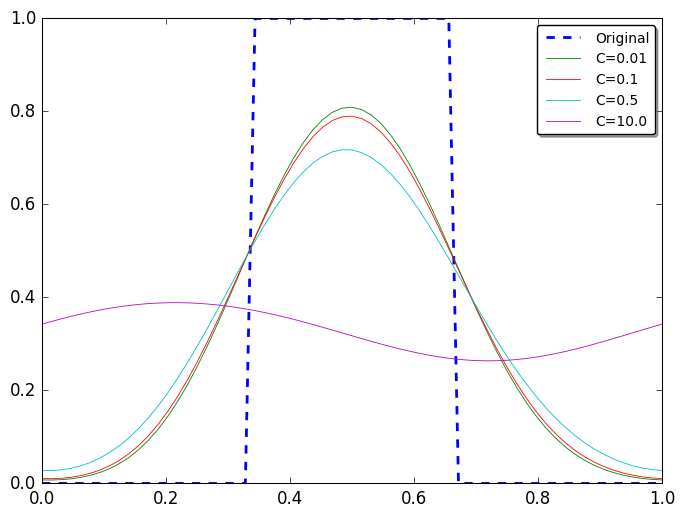

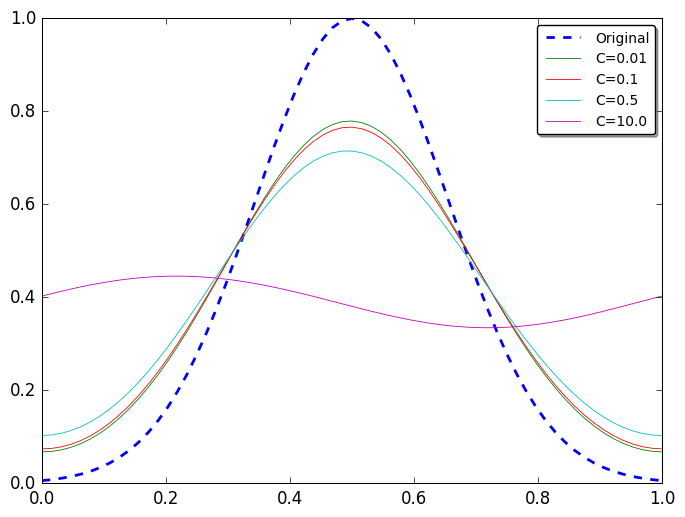

In [17]:
def CHT_E3_extra_1():
    import scipy.signal as signal
    class Profile:
        def __init__(self, N, shape): # N = number of finite-difference points - 1
            self.x, self.dx, self.u = np.arange(N)/(N-1), 1./(N-1), 1.0
            self.T = 1.0/self.u
            self.a = np.zeros(N)
            if shape == "Gaussian":
                self.a = signal.gaussian(N, std=int(N/6))
            elif shape == "top-hat":
                self.a[np.logical_and(self.x >= 1./3., self.x <= 2./3.)] = 1.0
            else:
                print("Unrecognized shape.")
                return
        def update(self, nT, C): # nT = number of periods to run, C = CFL number
            self.dt = C * self.dx / self.u
            Mat = np.zeros([len(self.a)-1, len(self.a)-1])
            Mat[0][0] = 1+C; Mat[0][-1] = -C
            for j in range(len(self.a)-1):
                if j != 0:
                    Mat[j][j-1:j+1] = [-C, 1+C]
            for i in range(int(nT/self.dt)):
                self.a[1:] = np.linalg.solve(Mat, self.a[1:]) # remember this
                self.a[0] = self.a[-1]
                
    def compareC(N, shape, nT):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        Cs = [0.01, 0.1, 0.5, 10.0]
        pf = Profile(N, shape)
        ax.plot(pf.x, pf.a, "--", lw=2, label="Original")
        for item in Cs:
            pf = Profile(N, shape)
            pf.update(nT, item)
            ax.plot(pf.x, pf.a, label=r"C="+str(item))
        leg = ax.legend(loc="best", handlelength=3, fancybox=True, shadow=True)
        leg.get_frame().set_alpha(1.0)
        plt.show()    
        plt.close("all")
    
    compareC(65, "top-hat", 1)
    compareC(65, "Gaussian", 1)
CHT_E3_extra_1()

### Exercise 3.6
Write a second-order solver for the linear advection equation. To mimic a real hydrodynamics code, your code should have routines for finding initializing the state, filling boundary conditions, computing the timestep, computing the interface states, solving the Riemann problem, and doing the update. The problem flow should look like:
- set initial conditions
- main evolution loop—loop until final time reached
- fill boundary conditions – get timestep (Eq. 3.5)
- compute interface states (Eqs. 3.18 and 3.19)
- solve Riemann problem at all interfaces (Eq. 3.22) – do conservative update (Eq. 3.16)

Use both the top-hat and Gaussian initial conditions and periodic boundary conditions and compare to the first-order method.

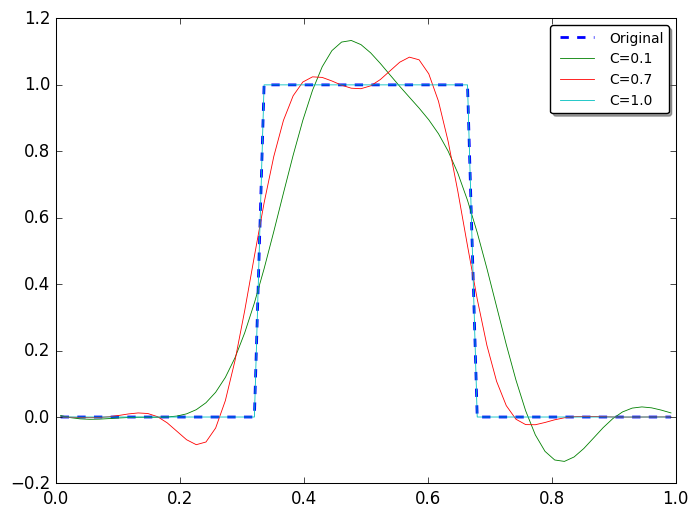

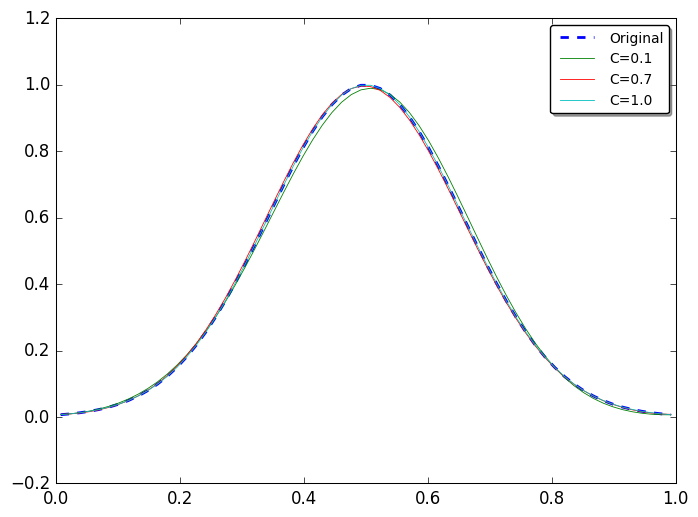

In [19]:
def CHT_E3_6():
    import scipy.signal as signal
    class Profile:
        def __init__(self, N, shape): # N = number of finite-volume cells
            self.x, self.dx, self.u = (np.arange(N)+0.5)/N, 1./N, 1.0
            self.T = 1.0/self.u
            self.a = np.zeros(N)
            if shape == "Gaussian":
                self.a = signal.gaussian(N, std=int(N/6))
            elif shape == "top-hat":
                self.a[np.logical_and(self.x >= 1./3., self.x <= 2./3.)] = 1.0
            else:
                print("Unrecognized shape.")
                return
        def update(self, nT, C): # nT = number of periods to run, C = CFL number
            self.dt = C * self.dx / self.u
            for i in range(int(nT/self.dt)):
                a_left_value = np.roll(self.a, 1)
                a_right_value = np.roll(self.a, -1)
                papx_i = (a_right_value-a_left_value)/(2*self.dx)
                f_L = self.u * (self.a + self.dx/2 * (1-C)*papx_i) # since u>0
                f_L_left_value = np.roll(f_L, 1)
                self.a = self.a - self.dt * (f_L - f_L_left_value) / self.dx
                
    def compareC(N, shape, nT):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        Cs = [0.1, 0.7, 1.0]
        pf = Profile(N, shape)
        ax.plot(pf.x, pf.a, "--", lw=2, label="Original")
        for item in Cs:
            pf = Profile(N, shape)
            pf.update(nT, item)
            ax.plot(pf.x, pf.a, label=r"C="+str(item))
        ax.set_ylim([-0.2, 1.2])
        leg = ax.legend(loc="best", handlelength=3, fancybox=True, shadow=True)
        leg.get_frame().set_alpha(1.0)
        plt.show()    
        plt.close("all")
    
    compareC(64, "top-hat", 5)
    compareC(64, "Gaussian", 5)
CHT_E3_6()

### Exercise 3.7
To remove the oscillations in practice, we limit the slopes to ensure that no new minima or maxima are introduced during the advection process. There are many choices for limited slopes. A popular one is the minmod limiter. Here, we construct the slopes in the interface states as:
$$\left.\frac{\partial a}{\partial x}\right|_i = \mathrm{minmod}\left(\frac{a_i-a_{i-1}}{\Delta x},\frac{a_{i+1}-a_i}{\Delta x}\right)$$
instead of Eq. 3.20. with
$$\mathrm{minmod(a,b)} = \left\{
\begin{array}{ccccc}      
    a & \mathrm{if}\ |a|<|b| \ \mathrm{and}\ a\cdot b>0 \\
    b & \mathrm{if}\ |b|<|a| \ \mathrm{and}\ a\cdot b>0 \\
    0 & \mathrm{otherwise}
\end{array}\right.$$
Use this slope in your second-order advection code and notice that the oscillations go away—see Figure 3.7.

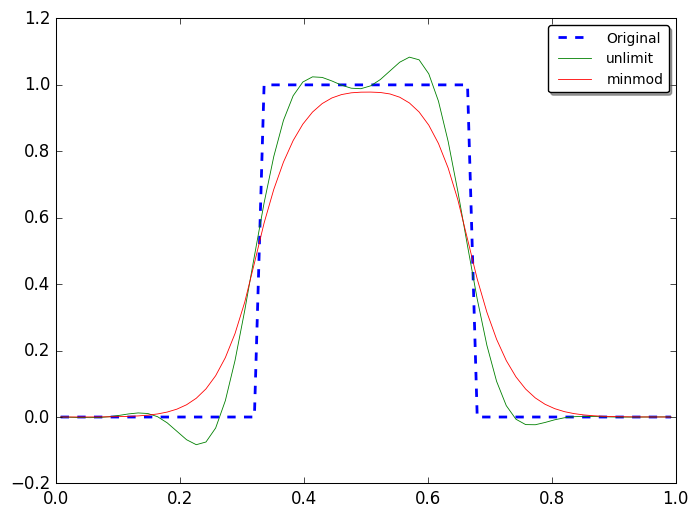

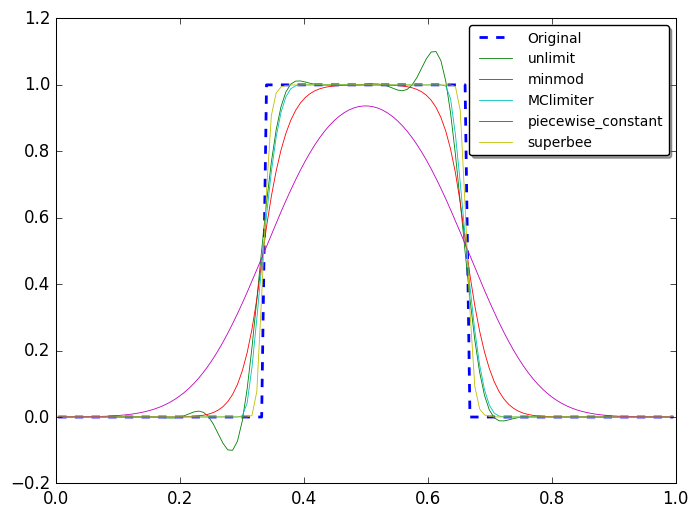

In [53]:
def CHT_E3_7():
    import scipy.signal as signal
    class Profile:
        def __init__(self, N, shape): # N = number of finite-volume cells
            self.x, self.dx, self.u = (np.arange(N)+0.5)/N, 1./N, 1.0
            self.T = 1.0/self.u
            self.a = np.zeros(N)
            if shape == "Gaussian":
                self.a = signal.gaussian(N, std=int(N/6))
            elif shape == "top-hat":
                self.a[np.logical_and(self.x >= 1./3., self.x <= 2./3.)] = 1.0
            else:
                print("Unrecognized shape.")
                return
        class Limiting:
            def __init__(self):
                pass
            def unlimit(self, a, dx):
                a_left_value = np.roll(a, 1); a_right_value = np.roll(a, -1)
                papx_i = (a_right_value-a_left_value)/(2*dx)
                return papx_i
            def minmod(self, a, dx):
                a_left_value = np.roll(a, 1); a_right_value = np.roll(a, -1)
                papx_i_L = (a - a_left_value)/dx; papx_i_R = (a_right_value - a)/dx
                papx_i = np.zeros(len(a))
                for i in range(len(a)): # Use Python Ternary Statement to simplify the code
                    papx_i[i] = 0 if papx_i_L[i]*papx_i_R[i] < 0 else \
                    (papx_i_L[i] if abs(papx_i_L[i]) < abs(papx_i_R[i]) else papx_i_R[i])
                return papx_i
            def MClimiter(self, a, dx):
                a_left_value = np.roll(a, 1); a_right_value = np.roll(a, -1)
                xi = (a_right_value - a)*(a - a_left_value)
                papx_i_RL = (a_right_value - a_left_value) / (2*dx)
                papx_i_L = (a - a_left_value)/dx; papx_i_R = (a_right_value - a)/dx
                papx_i = np.zeros(len(a)); non0 = np.where(xi>0)
                papx_i[non0] = np.min([abs(papx_i_RL[non0]), 2*abs(papx_i_L[non0]), 2*abs(papx_i_R[non0])], 0)*\
                                np.sign(a_right_value[non0]-a_left_value[non0])
                return papx_i
            def piecewise_constant(self, a, dx):
                return np.zeros(len(a))
            def superbee(self, a, dx):
                a_left_value = np.roll(a, 1); a_right_value = np.roll(a, -1)
                papx_i_L = (a - a_left_value)/dx; papx_i_R = (a_right_value - a)/dx
                papx_i_A = np.zeros(len(a)); papx_i_B = np.zeros(len(a)); papx_i = np.zeros(len(a))
                for i in range(len(a)):
                    papx_i_A[i] = papx_i_L[i] if abs(papx_i_L[i]) < abs(2*papx_i_R[i]) else 2*papx_i_R[i]
                    papx_i_B[i] = 2*papx_i_L[i] if abs(2*papx_i_L[i]) < abs(papx_i_R[i]) else papx_i_R[i]
                    papx_i[i] = 0 if papx_i_L[i]*papx_i_R[i] < 0 else \
                                (papx_i_A[i] if abs(papx_i_A[i]) > abs(papx_i_B[i]) else papx_i_B[i])
                return papx_i
                
        def update(self, nT, C, limit): # nT = number of periods to run, C = CFL number
            self.dt = C * self.dx / self.u
            limiting = self.Limiting()
            for i in range(int(nT/self.dt)):
                papx_i = getattr(limiting, limit)(self.a, self.dx)
                f_L = self.u * (self.a + self.dx/2 * (1-C)*papx_i) # since u>0
                f_L_left_value = np.roll(f_L, 1)
                self.a = self.a - self.dt * (f_L - f_L_left_value) / self.dx
                
    def compareC(N, shape, nT, C, n_limiters):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        limitings = ["unlimit", "minmod", "MClimiter", "piecewise_constant", "superbee"]
        pf = Profile(N, shape)
        ax.plot(pf.x, pf.a, "--", lw=2, label="Original")
        for item in limitings[:n_limiters]:
            pf = Profile(N, shape)
            pf.update(nT, C, item)
            ax.plot(pf.x, pf.a, label=str(item))
        ax.set_ylim([-0.2, 1.2])
        leg = ax.legend(loc="best", handlelength=3, fancybox=True, shadow=True)
        leg.get_frame().set_alpha(1.0)
        plt.show()    
        plt.close("all")
    compareC(64, "top-hat", 5, 0.7, 2)
    compareC(128, "top-hat", 5, 0.8, 5)
CHT_E3_7()

### Exercise 3.8
Show analytically that if you fully limit the slopes (i.e. set $\partial a/\partial x|_i = 0$), that the second-order method reduces to precisely our first- order finite-difference discretization, Eq. 3.2.

If fully limiting the slopes, then the states on the interfaces become the value of cell center at integer time step.
$$a^{n+1/2}_{i+1/2,L} = a_i^n\ \ \ \ \ a^{n+1/2}_{i+1/2,R} = a_{i+1}^n$$
Therefore, Eq. 3.16 becomes
$$\frac{a^{n+1}_i - a^n_i}{\Delta t} = -u\frac{a^n_i - a^n_{i-1}}{\Delta x}$$
*QED* (Quod Erat Demonstrandum).

### Exercise 3.9 
Run the first-order solver for several different $\Delta x$s, each a factor of 2 smaller than the previous. Compute $\epsilon$ for each resolution and observe that it converges in a first-order fashion (i.e. $\epsilon$ decreases by 2 when we decrease $\Delta x$ by a factor of 2).

Do the same with the second-order solver and observe that it converges as second-order. However: you may find less than second-order is your initial conditions have discontinuities and you are limiting. Show the convergence of the method with minmod limiting, $C = 0.8$, and a Gaussian initial condition.

32 0.03125 0.17427981937 0.045004739511
64 0.015625 0.107472611157 0.0174011937099
128 0.0078125 0.0584460242955 0.00571765266817
256 0.00390625 0.0314107427878 0.00185968816033
512 0.001953125 0.0160933858 0.000610901281383


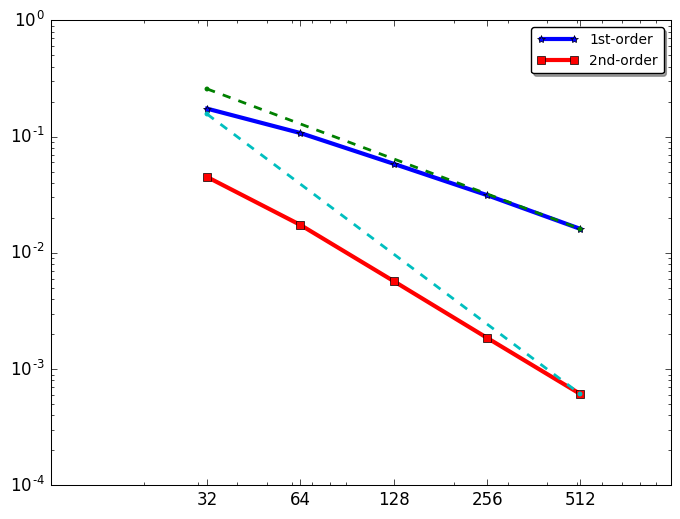

In [11]:
def CHT_E3_8():
    import scipy.signal as signal
    class Profile:
        def __init__(self, N, shape): # N = number of finite-volume cells
            self.x, self.dx, self.u = (np.arange(N)+0.5)/N, 1./N, 1.0
            self.T = 1.0/self.u
            self.a = np.zeros(N)
            if shape == "Gaussian":
                self.a = signal.gaussian(N, std=int(N/6))
            elif shape == "top-hat":
                self.a[np.logical_and(self.x >= 1./3., self.x <= 2./3.)] = 1.0
            else:
                print("Unrecognized shape.")
            self.a0 = self.a
            return
        class Limiting:
            def __init__(self):
                pass
            def piecewise_constant(self, a, dx):
                return np.zeros(len(a))
            def minmod(self, a, dx):
                a_left_value = np.roll(a, 1); a_right_value = np.roll(a, -1)
                papx_i_L = (a - a_left_value)/dx; papx_i_R = (a_right_value - a)/dx
                papx_i = np.zeros(len(a))
                for i in range(len(a)): # Use Python Ternary Statement to simplify the code
                    papx_i[i] = 0 if papx_i_L[i]*papx_i_R[i] < 0 else \
                    (papx_i_L[i] if abs(papx_i_L[i]) < abs(papx_i_R[i]) else papx_i_R[i])
                return papx_i
        def norm_of_error(self):
            self.error = np.sqrt(np.sum((self.a - self.a0)**2)*self.dx); return self.error
        def update(self, nT, C, limit): # nT = number of periods to run, C = CFL number
            self.dt = C * self.dx / self.u
            limiting = self.Limiting()
            for i in range(int(nT/self.dt)):
                papx_i = getattr(limiting, limit)(self.a, self.dx)
                f_L = self.u * (self.a + self.dx/2 * (1-C)*papx_i) # since u>0
                f_L_left_value = np.roll(f_L, 1)
                self.a = self.a - self.dt * (f_L - f_L_left_value) / self.dx
            return self.norm_of_error()
                
    def compareC(shape, nT, C):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        N = [32, 64, 128, 256, 512]
        error1O = np.zeros(len(N)); error2O = np.zeros(len(N))
        for i, item in enumerate(N):
            pf = Profile(item, shape)
            error1O[i] = pf.update(nT, C, "piecewise_constant")
            pf = Profile(item, shape)
            error2O[i] = pf.update(nT, C, "minmod")
            print(item, 1.0/item, error1O[i], error2O[i])
        ax.loglog(N, error1O, '*-', label="1st-order", lw=3)
        ax.loglog([N[0], N[-1]], [16*error1O[-1], error1O[-1]], '--.', lw = 2)
        ax.loglog(N, error2O, 's-', label="2nd-order", lw=3)
        ax.loglog([N[0], N[-1]], [256*error2O[-1], error2O[-1]], '--.', lw = 2)
        ax.set_xticks(N); ax.set_xticklabels([str(n) for n in N])
        """Somehow the 2nd-order goes as ~1/3 while increasing N to 2N, there must be something wrong here."""
        leg = ax.legend(loc="best", handlelength=3, fancybox=True, shadow=True)
        leg.get_frame().set_alpha(1.0)
        plt.show()    
        plt.close("all")
    compareC("Gaussian", 5, 0.8)
CHT_E3_8()

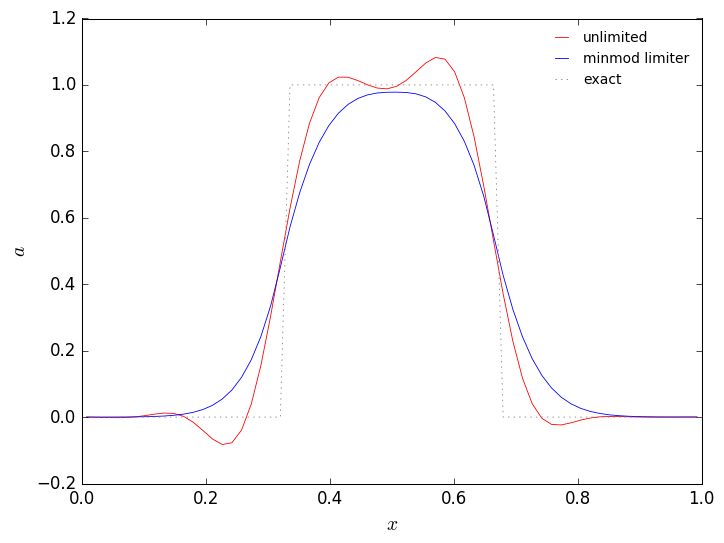

0.03125 32 0.0389358876219
0.015625 64 0.00968671199259
0.0078125 128 0.00228462364604
0.00390625 256 0.000557638063044
0.001953125 512 0.000138442098283


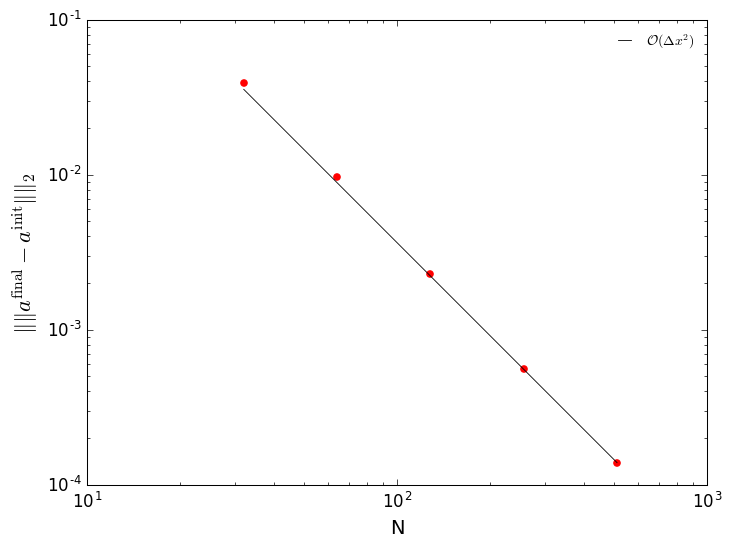

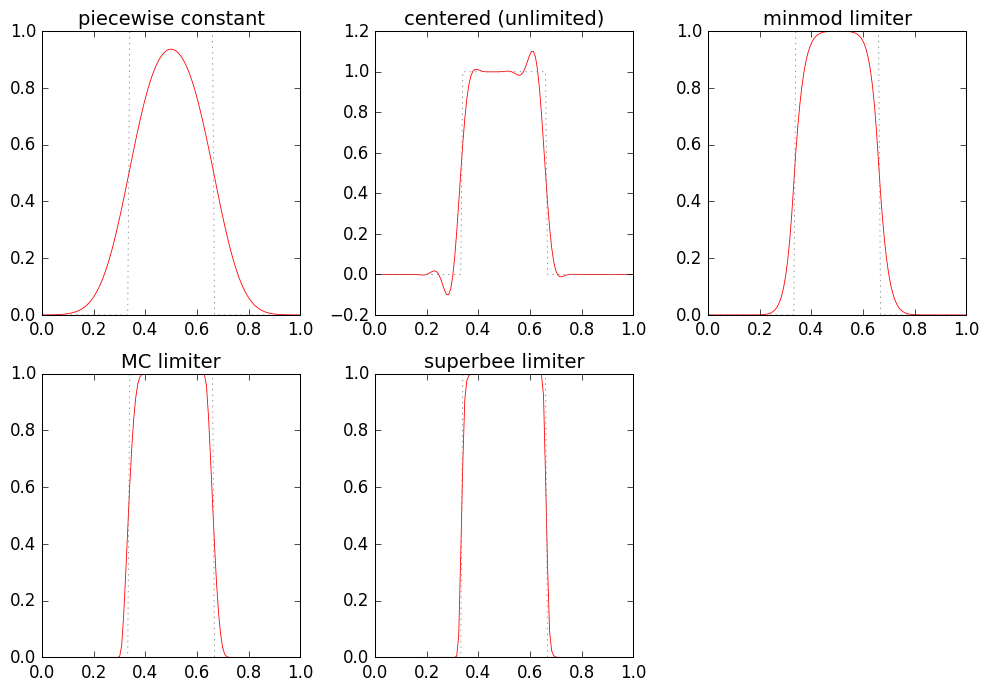

In [9]:
"""
2nd-order accurate finite-volume implementation of linear advection with 
piecewise linear slope reconstruction.
We are solving a_t + u a_x = 0
This script defines two classes:
 -- the Grid1d class that manages a cell-centered grid and holds the 
    data that lives on that grid
 -- the Simulation class that is built on a Grid1d object and defines
    everything needed to do a advection.
Options for several different slope limiters are provided.
M. Zingale
"""
import numpy, pylab, math

# helper functions for the limiting
def minmod(a, b):
    if (abs(a) < abs(b) and a*b > 0.0):
        return a
    elif (abs(b) < abs(a) and a*b > 0.0):
        return b
    else:
        return 0.0

def maxmod(a, b):
    if (abs(a) > abs(b) and a*b > 0.0):
        return a
    elif (abs(b) > abs(a) and a*b > 0.0):
        return b
    else:
        return 0.0

class Grid1d:
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):
        self.ng = ng
        self.nx = nx
        self.xmin = xmin
        self.xmax = xmax
        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1
        # physical coords -- cell-centered, left and right edges
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (numpy.arange(nx+2*ng)-ng+0.5)*self.dx
        # storage for the solution
        self.a = numpy.zeros((nx+2*ng), dtype=numpy.float64)
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return numpy.zeros((self.nx+2*self.ng), dtype=numpy.float64)
    def fill_BCs(self):
        """ fill all single ghostcell with periodic boundary conditions """
        n = 0
        while n < self.ng:
            # left boundary
            self.a[self.ilo-1-n] = self.a[self.ihi-n]
            # right boundary
            self.a[self.ihi+1+n] = self.a[self.ilo+n]
            n += 1
    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None
        return numpy.sqrt(self.dx*numpy.sum(e[self.ilo:self.ihi+1]**2))
class Simulation:
    def __init__(self, grid, u, C=0.8, slope_type="centered"):
        self.grid = grid
        self.t = 0.0 # simulation time
        self.u = u   # the constant advective velocity
        self.C = C   # CFL number
        self.slope_type = slope_type
    def init_cond(self, type="tophat"):
        """ initialize the data """
        if type == "tophat":
            self.grid.a[:] = 0.0
            self.grid.a[numpy.logical_and(self.grid.x >= 0.333, 
                                          self.grid.x <= 0.666)] = 1.0
        elif type == "sine":
            self.grid.a[:] = numpy.sin(2.0*math.pi*self.grid.x/(self.grid.xmax-self.grid.xmin))
        elif type == "gaussian":
            self.grid.a[:] = 1.0 + numpy.exp(-60.0*(self.grid.x - 0.5)**2)
    def timestep(self):
        """ return the advective timestep """
        return self.C*self.grid.dx/self.u
    def period(self):
        """ return the period for advection with velocity u """
        return (self.grid.xmax - self.grid.xmin)/self.u
    def states(self, dt):
        """ compute the left and right interface states """
        # compute the piecewise linear slopes
        g = self.grid
        slope = g.scratch_array()
        g = self.grid
        if self.slope_type == "godunov":
            # piecewise constant = 0 slopes
            slope[:] = 0.0
        elif self.slope_type == "centered":
            # unlimited centered difference slopes
            i = g.ilo-1
            while i <= g.ihi+1:
                slope[i] = 0.5*(g.a[i+1] - g.a[i-1])/g.dx
                i += 1
        elif self.slope_type == "minmod":
            # minmod limited slope
            i = g.ilo-1
            while i <= g.ihi+1:
                slope[i] = minmod( (g.a[i] - g.a[i-1])/g.dx, 
                                   (g.a[i+1] - g.a[i])/g.dx )
                i += 1
        elif self.slope_type == "MC":
            # MC limiter
            i = g.ilo-1
            while i <= g.ihi+1:
                slope[i] = minmod(minmod( 2.0*(g.a[i] - g.a[i-1])/g.dx, 
                                          2.0*(g.a[i+1] - g.a[i])/g.dx ),
                                  0.5*(g.a[i+1] - g.a[i-1])/g.dx)
                i += 1
        elif self.slope_type == "superbee":
            # superbee limiter
            i = g.ilo-1
            while i <= g.ihi+1:
                A = minmod( (g.a[i+1] - g.a[i])/g.dx,
                            2.0*(g.a[i] - g.a[i-1])/g.dx )
                B = minmod( (g.a[i] - g.a[i-1])/g.dx,
                            2.0*(g.a[i+1] - g.a[i])/g.dx )
                slope[i] = maxmod(A, B)
                i += 1
        # loop over all the interfaces.  Here, i refers to the left
        # interface of the zone.  Note that thre are 1 more interfaces
        # than zones
        al = g.scratch_array()
        ar = g.scratch_array()
        i = g.ilo
        while i <= g.ihi+1:
            # left state on the current interface comes from zone i-1
            al[i] = g.a[i-1] + 0.5*g.dx*(1.0 - u*dt/g.dx)*slope[i-1]
            # right state on the current interface comes from zone i
            ar[i] = g.a[i] - 0.5*g.dx*(1.0 + u*dt/g.dx)*slope[i]
            i += 1
        return al, ar
    def riemann(self, al, ar):
        """ 
        Riemann problem for advection -- this is simply upwinding,
        but we return the flux 
        """
        if self.u > 0.0:
            return self.u*al
        else:
            return self.u*ar
    def update(self, dt, flux):
        """ conservative update """
        g = self.grid
        anew = g.scratch_array()
        anew[g.ilo:g.ihi+1] = g.a[g.ilo:g.ihi+1] + \
            dt/g.dx * (flux[g.ilo:g.ihi+1] - flux[g.ilo+1:g.ihi+2])
        return anew
    def evolve(self, num_periods=1):
        """ evolve the linear advection equation """
        self.t = 0.0
        g = self.grid
        tmax = num_periods*self.period()
        # main evolution loop
        while (self.t < tmax):
            # fill the boundary conditions
            g.fill_BCs()
            # get the timestep
            dt = self.timestep()
            if (self.t + dt > tmax):
                dt = tmax - self.t
            # get the interface states
            al, ar = self.states(dt)
            # solve the Riemann problem at all interfaces
            flux = self.riemann(al, ar)
            # do the conservative update
            anew = self.update(dt, flux)
            g.a[:] = anew[:]
            self.t += dt
if __name__ == "__main__":
    #-------------------------------------------------------------------------
    # compare limiting and no-limiting
    xmin = 0.0
    xmax = 1.0
    nx = 64
    ng = 2
    g = Grid1d(nx, ng, xmin=xmin, xmax=xmax)
    u = 1.0
    s = Simulation(g, u, C=0.7, slope_type="centered")
    s.init_cond("tophat")
    ainit = s.grid.a.copy()
    s.evolve(num_periods=5)
    pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], 
               color="r", label="unlimited")
    s = Simulation(g, u, C=0.7, slope_type="minmod")
    s.init_cond("tophat")
    s.evolve(num_periods=5)
    pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], 
               color="b", label="minmod limiter")
    pylab.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], 
               ls=":", color="0.5", label="exact")
    pylab.legend(frameon=False, loc="best")
    pylab.xlabel(r"$x$")
    pylab.ylabel(r"$a$")
    pylab.show()
    #pylab.savefig("fv-advect.eps")
    #-------------------------------------------------------------------------
    # convergence test
    problem = "gaussian"
    xmin = 0.0
    xmax = 1.0
    ng = 2
    N = [32, 64, 128, 256, 512]
    err = []
    for nx in N:
        g = Grid1d(nx, ng, xmin=xmin, xmax=xmax)
        u = 1.0
        s = Simulation(g, u, C=0.8, slope_type="centered")
        s.init_cond("gaussian")
        ainit = s.grid.a.copy()
        s.evolve(num_periods=5)
        # compute the error
        err.append(g.norm(g.a - ainit))
        print(g.dx, nx, err[-1])
    pylab.clf()
    N = numpy.array(N, dtype=numpy.float64)
    err = numpy.array(err)
    pylab.scatter(N, err, color="r")
    pylab.plot(N, err[len(N)-1]*(N[len(N)-1]/N)**2, 
               color="k", label=r"$\mathcal{O}(\Delta x^2)$")
    ax = pylab.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    pylab.xlabel("N")
    pylab.ylabel(r"$\|\| a^\mathrm{final} - a^\mathrm{init} \|\|_2$", 
                 fontsize=16)
    pylab.legend(frameon=False)
    pylab.show()
    #pylab.savefig("plm-converge.png")
    #-------------------------------------------------------------------------
    # different limiters: run both the Gaussian and tophat
    xmin = 0.0
    xmax = 1.0
    nx = 128
    ng = 2
    u = 1.0
    g= Grid1d(nx, ng, xmin=xmin, xmax=xmax)
    for p in ["gaussian", "tophat"]:
        pylab.clf()
        s = Simulation(g, u, C=0.8, slope_type="godunov")
        s.init_cond(p)
        ainit = s.grid.a.copy()
        s.evolve(num_periods=5)
        pylab.subplot(231)
        pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], color="r")
        pylab.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], ls=":", color="0.5")
        pylab.title("piecewise constant")
        s = Simulation(g, u, C=0.8, slope_type="centered")
        s.init_cond(p)
        ainit = s.grid.a.copy()
        s.evolve(num_periods=5)
        pylab.subplot(232)
        pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], color="r")
        pylab.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], ls=":", color="0.5")
        pylab.title("centered (unlimited)")
        s = Simulation(g, u, C=0.8, slope_type="minmod")
        s.init_cond(p)
        ainit = s.grid.a.copy()
        s.evolve(num_periods=5)
        pylab.subplot(233)
        pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], color="r")
        pylab.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], ls=":", color="0.5")
        pylab.title("minmod limiter")
        s = Simulation(g, u, C=0.8, slope_type="MC")
        s.init_cond(p)
        ainit = s.grid.a.copy()
        s.evolve(num_periods=5)
        pylab.subplot(234)
        pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], color="r")
        pylab.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], ls=":", color="0.5")
        pylab.title("MC limiter")
        s = Simulation(g, u, C=0.8, slope_type="superbee")
        s.init_cond(p)
        ainit = s.grid.a.copy()
        s.evolve(num_periods=5)
        pylab.subplot(235)
        pylab.plot(g.x[g.ilo:g.ihi+1], g.a[g.ilo:g.ihi+1], color="r")
        pylab.plot(g.x[g.ilo:g.ihi+1], ainit[g.ilo:g.ihi+1], ls=":", color="0.5")
        pylab.title("superbee limiter")
        f = pylab.gcf()
        f.set_size_inches(10.0,7.0)
        pylab.tight_layout()
        #pylab.savefig("fv-{}-limiters.png".format(p), bbox_inches="tight")